
# evaluate Relations

check which hybrid performed best do we prefer precision or recall

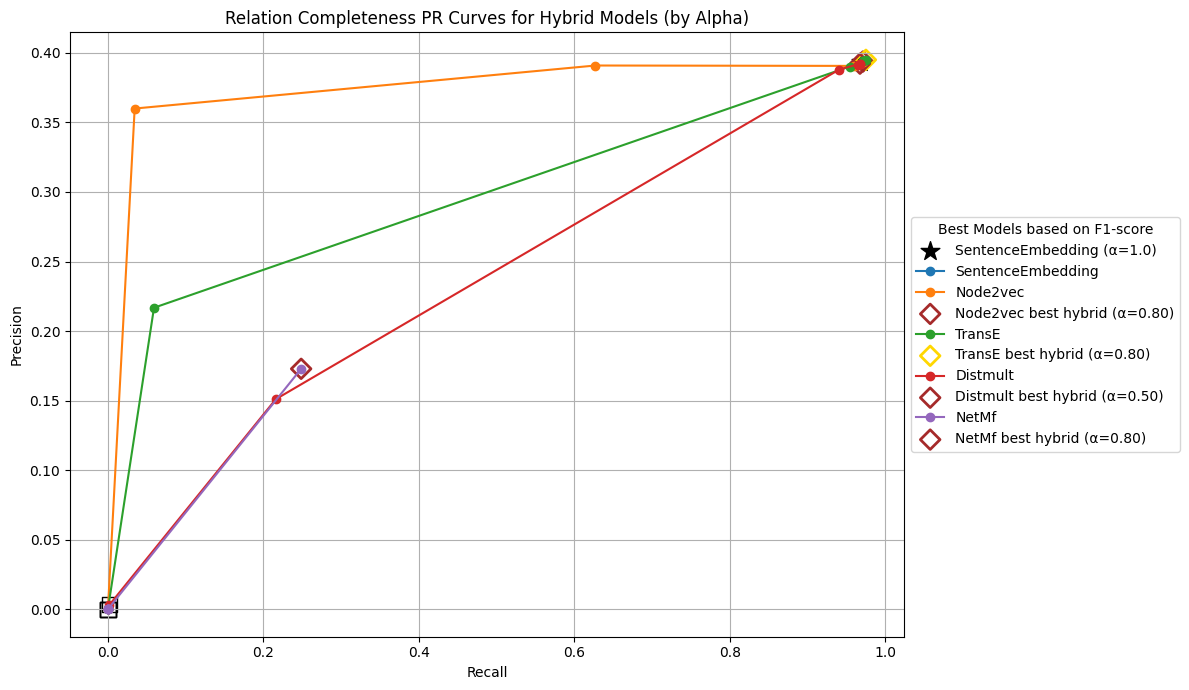

In [ ]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Path and file setup
match_dir = f"matches_relation"

golden_standard = pd.read_csv(f'data/test_golden_standard_relation.csv')
model_bases = {
    'SentenceEmbedding': "SentenceEmbedding",
    'Node2vec': "HybridNode2vecLow_alpha_",
    'TransE': "HybridTransE_alpha_",
    'Distmult': "HybridDistmult_alpha_",
    'NetMf': "HybridNetMf_alpha_",
}
alpha_values = [round(i * 0.05, 2) for i in range(21)]   # 0.0 to 0.95 in steps of 0.05

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

def evaluate_matches(match_data, golden_standard):
    identifiers = []
    true_duplicate_pairs = set()
    for match in match_data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        # Always add all pairs to identifiers
        identifiers.append(pair)
        # If this match is an exact/true duplicate, remember the pair
        if match.get('duplication_type') == 'true_duplicate':
            # Use sorted tuple to be order-agnostic
            uuid1, uuid2 = pair['entity1'], pair['entity2']
            true_duplicate_pairs.add(tuple(sorted([uuid1, uuid2])))
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    # Filter out 'true_duplicate' pairs from the false positives
    false_positives = (matched_pairs_set - golden_pairs_set) - true_duplicate_pairs

    TP = len([
        1 for pair in matched_pairs_set if pair in golden_pairs_set
    ])
    FP = len(false_positives)
    FN = len(golden_pairs_set - matched_pairs_set)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

# Prepare to store results
pr_curves = {model: {'precisions': [], 'recalls': [], 'alphas': []} for model in model_bases.keys()}

for model, base in model_bases.items():
    for alpha in alpha_values:
        if alpha == 1.0:
            filename = os.path.join(match_dir, "SentenceEmbedding.json")
        else:
            filename = os.path.join(match_dir, f"{base}{alpha}.json")
        if not os.path.exists(filename):
            continue
        with open(filename, 'r') as f:
            match_data = json.load(f)
        precision, recall = evaluate_matches(match_data, golden_standard)
        pr_curves[model]['precisions'].append(precision)
        pr_curves[model]['recalls'].append(recall)
        pr_curves[model]['alphas'].append(alpha)

# Find the best model and alpha (highest F1 among all models and alphas except alpha=1.0)
best_model = None
best_alpha = None
best_f1 = -1
best_idx = None

for model, curve in pr_curves.items():
    for i, (p, r, a) in enumerate(zip(curve['precisions'], curve['recalls'], curve['alphas'])):
        if a == 1.0:
            continue  # skip SentenceEmbedding
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_alpha = a
            best_idx = i

plt.figure(figsize=(12, 7))

# Plot SentenceEmbedding (alpha=1.0) only once
if 'SentenceEmbedding.json' in [os.path.basename(os.path.join(match_dir, "SentenceEmbedding.json"))]:
    se_precision, se_recall = None, None
    for model, curve in pr_curves.items():
        for i, alpha in enumerate(curve['alphas']):
            if alpha == 1.0:
                se_precision = curve['precisions'][i]
                se_recall = curve['recalls'][i]
                break
    if se_precision is not None and se_recall is not None:
        plt.scatter(se_recall, se_precision, marker='*', s=200, color='black', label='SentenceEmbedding (α=1.0)')

# Plot each model's PR curve, highlight best hybrid, and highlight alpha=0.0
for model, curve in pr_curves.items():
    hybrid_recalls = [r for a, r in zip(curve['alphas'], curve['recalls']) if a != 1.0]
    hybrid_precisions = [p for a, p in zip(curve['alphas'], curve['precisions']) if a != 1.0]
    hybrid_alphas = [a for a in curve['alphas'] if a != 1.0]
    if hybrid_recalls:
        max_recall = max(hybrid_recalls)
        idx_max_recall = hybrid_recalls.index(max_recall)
        print(f"Model: {model}, Highest Recall: {max_recall:.4f} at alpha={hybrid_alphas[idx_max_recall]:.2f}, Precision: {hybrid_precisions[idx_max_recall]:.4f}")
    # plot and capture line color
    line = plt.plot(hybrid_recalls, hybrid_precisions, marker='o', markersize = 4 ,label=model)
    line_color = line[0].get_color()
    # Highlight starting point (alpha=0.0)
    if 0.0 in curve['alphas']:
        idx0 = curve['alphas'].index(0.0)
        plt.scatter(curve['recalls'][idx0], curve['precisions'][idx0], marker='s', s=120, color='none', edgecolor='black')
    # Find best hybrid (highest F1)
    best_idx_model = None
    best_f1_model = -1
    for i, (p, r) in enumerate(zip(hybrid_precisions, hybrid_recalls)):
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1_model:
            best_f1_model = f1
            best_idx_model = i
    if best_idx_model is not None:
        marker_color = 'gold' if model == best_model else line_color
        plt.scatter(
            hybrid_recalls[best_idx_model],
            hybrid_precisions[best_idx_model],
            marker='D', s=100,
            edgecolor=marker_color,
            facecolor='none',
            linewidths=2,
            label=f"{model} top F1-score (α={hybrid_alphas[best_idx_model]:.2f})"
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Syntactic Variations PR Curves for Hybrid Models (by Alpha)')
plt.legend(
    loc='center left',       # place legend to the right
    bbox_to_anchor=(1, 0.5), # shift legend outside plot
    title='Best Models based on F1-score',  # legend header title
    frameon=True
)
plt.grid(True)
plt.tight_layout()
plt.show()

Use the Best hybrid and compare the methods to one another


=== SentenceEmbeddings ===
Predicted pairs: 1289
True Duplicates Predicted: 0
True Positives: 507
False Positives: 782
False Negatives: 16
Precision: 0.3933
Recall: 0.9694
F1 Score: 0.5596

=== TransE 0.8 ===
Predicted pairs: 1291
True Duplicates Predicted: 0
True Positives: 510
False Positives: 781
False Negatives: 13
Precision: 0.3950
Recall: 0.9751
F1 Score: 0.5623

=== Distmult 0.5 ===
Predicted pairs: 1290
True Duplicates Predicted: 0
True Positives: 506
False Positives: 784
False Negatives: 17
Precision: 0.3922
Recall: 0.9675
F1 Score: 0.5582

=== NetMf 0.8 ===
Predicted pairs: 752
True Duplicates Predicted: 0
True Positives: 130
False Positives: 622
False Negatives: 393
Precision: 0.1729
Recall: 0.2486
F1 Score: 0.2039

=== Node2vec 0.8 ===
Predicted pairs: 1290
True Duplicates Predicted: 0
True Positives: 508
False Positives: 782
False Negatives: 15
Precision: 0.3938
Recall: 0.9713
F1 Score: 0.5604


Precision, Recall, F1 Score per Method:
                    Precision  Recall 

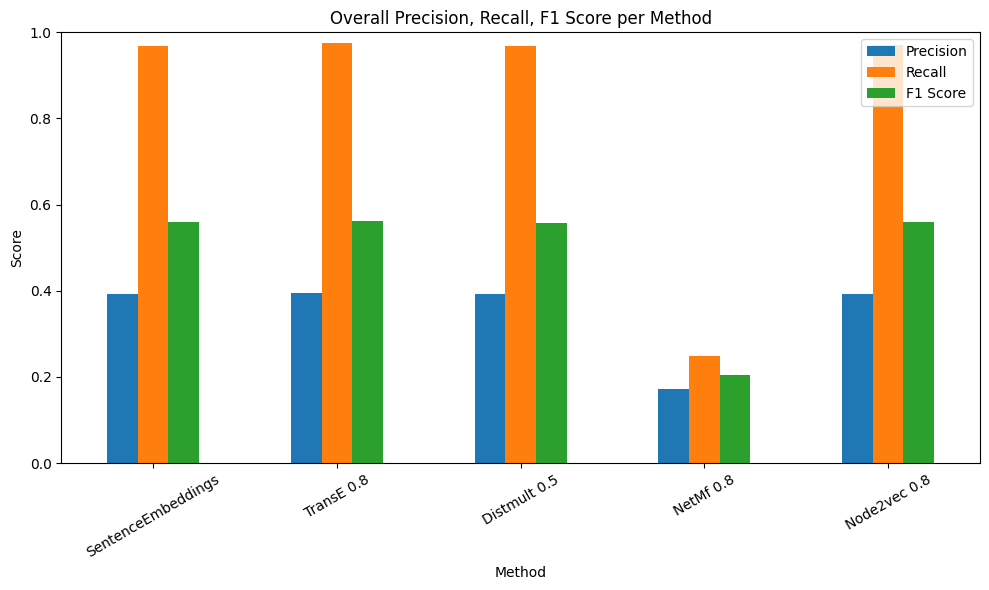

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt


golden_standard = pd.read_csv(f'data/test_golden_standard_relation.csv')

# Define which match files to analyze
match_files = {
    'SentenceEmbeddings': f'matches_relation/SentenceEmbedding.json',
    'TransE 0.8' : f'matches_relation/HybridTransE_alpha_0.8.json',
    'Distmult 0.5': f'matches_relation/HybridDistmult_alpha_0.5.json',
    'NetMf 0.8' : f'matches_relation/HybridNetMf_alpha_0.8.json',
    'Node2vec 0.8': f'matches_relation/HybridNode2vecLow_alpha_0.8.json',
}

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

precision_recall_summary = {}
percent_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Collect all predicted pairs & label exact matches in one pass ---
    pair_tuples = []
    true_dup_pairs = set()
    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        pair_tuples.append(pair)
        if match.get("duplication_type") == "true_duplicate":
            true_dup_pairs.add(pair)

    matched_pairs_set = set(pair_tuples)
    golden_pairs_set = set(
        tuple(sorted([row['original_id'], row['duplicate_id']]))
        for _, row in golden_standard.iterrows()
    )

    # -- Metrics: TP, FP (excluding true_duplicate not in golden), FN --
    TP = len(matched_pairs_set & golden_pairs_set)
    # Exclude predicted "exact/true_duplicate" pairs that are not in the golden set from FP
    FP = len((matched_pairs_set - golden_pairs_set) - true_dup_pairs)
    FN = len(golden_pairs_set - matched_pairs_set)

    predicted_not_in_golden = matched_pairs_set - golden_pairs_set
    true_duplicates_predicted = true_dup_pairs
    # Save in a summary dict for later
    if 'analysis' not in locals():
        analysis = {}
    analysis[match_type] = {
        'predicted_not_in_golden': list(predicted_not_in_golden),
        'true_duplicates_predicted': list(true_duplicates_predicted)}

    # # Optionally, also save to file for inspection
    # with open(f"{match_type}_predicted_not_in_golden.json", "w") as f:
    #     json.dump(list(predicted_not_in_golden), f)
    # with open(f"{match_type}_true_duplicates_predicted.json", "w") as f:
    #     json.dump(list(true_duplicates_predicted), f)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"=== {match_type} ===")
    print(f"Predicted pairs: {len(pair_tuples)}")
    print(f"True Duplicates Predicted: {sum(1 for match in data if match.get('duplication_type') == 'true_duplicate')}")
    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {F1_score:.4f}\n")

    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall, 'F1 Score': F1_score}

    # --- Analysis by variation/entity type: use golden_standard, mark which pairs matched ---
    golden_standard['pair_key'] = golden_standard.apply(
        lambda row: tuple(sorted([row['original_id'], row['duplicate_id']])), axis=1)
    golden_standard['matched'] = golden_standard['pair_key'].isin(matched_pairs_set)

    # Variation-type analysis
    variation_stats = golden_standard.groupby('variation_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    variation_stats['Matched (%)'] = variation_stats['Matched_Count'] / variation_stats['Golden_Standard_Count'] * 100

    # Entity-type analysis
    entity_stats = golden_standard.groupby('entity_type').agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    entity_stats['Matched (%)'] = entity_stats['Matched_Count'] / entity_stats['Golden_Standard_Count'] * 100

    # Combined variation/entity-type analysis
    combo_stats = golden_standard.groupby(['variation_type', 'entity_type']).agg(
        Golden_Standard_Count=('matched', 'count'),
        Matched_Count=('matched', 'sum')
    )
    combo_stats['Matched (%)'] = combo_stats['Matched_Count'] / combo_stats['Golden_Standard_Count'] * 100
    combo_stats = combo_stats.reset_index().sort_values(['variation_type', 'entity_type'])

    # Save for plotting
    percent_summary[match_type] = entity_stats['Matched (%)']

    # (Optional: print for debugging)
    # print(variation_stats)
    # print(entity_stats)
    # print(combo_stats)

# --- Final Reporting and Plotting ---
pr_df = pd.DataFrame(precision_recall_summary).T.round(4)
print("\nPrecision, Recall, F1 Score per Method:")
print(pr_df)

# Barplot: Percentage of matched duplicates by entity type
pr_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Overall Precision, Recall, F1 Score per Method')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



Precision/Recall/F1 per entity type for SentenceEmbeddings:
                        Precision  Recall      F1
HealthcareOrganization     0.3611  0.8667  0.5098
ServiceDepartment          0.4410  0.8938  0.5906
HealthcarePersonnel        1.0000  0.9949  0.9975

Precision/Recall/F1 per entity type for TransE 0.8:
                        Precision  Recall      F1
HealthcareOrganization     0.3947   1.000  0.5660
ServiceDepartment          0.4049   0.885  0.5556
HealthcarePersonnel        1.0000   1.000  1.0000

Precision/Recall/F1 per entity type for Distmult 0.5:
                        Precision  Recall      F1
HealthcareOrganization     0.3846  1.0000  0.5556
ServiceDepartment          0.4181  0.8584  0.5623
HealthcarePersonnel        1.0000  0.9975  0.9987

Precision/Recall/F1 per entity type for NetMf 0.8:
                        Precision  Recall      F1
HealthcareOrganization     0.0000  0.0000  0.0000
ServiceDepartment          0.3268  0.7345  0.4523
HealthcarePersonnel        1.

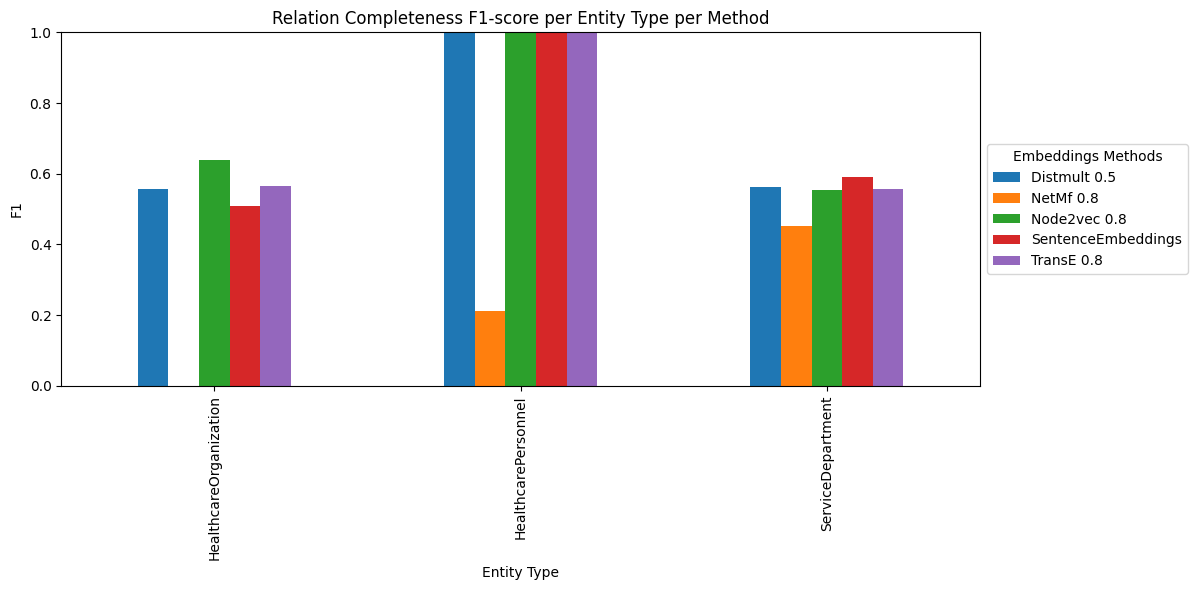

In [3]:
def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

entity_type_pr_summary = {}

for match_type, filepath in match_files.items():
    with open(filepath, 'r') as f:
        data = json.load(f)

    # --- Extract all predicted pairs and true_duplicate pairs once ---
    all_pairs = []
    all_pair_to_type = {}
    true_dup_pairs = set()

    for match in data:
        entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
        entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
        uuid1, uuid2 = extract_uuid(entity1.get("subject")), extract_uuid(entity2.get("subject"))
        pair = tuple(sorted([uuid1, uuid2]))
        all_pairs.append(pair)
        # Try to infer entity_type (from entity1 or entity2) if possible, or skip
        # (Here, you should store all types involved for later filtering)
        all_pair_to_type[pair] = None  # will filter per entity_type later
        if match.get("duplication_type") in ['true_duplicate', 'exact']:
            true_dup_pairs.add(pair)

    all_pairs_set = set(all_pairs)

    # -- Per-entity-type PRF calculation --
    prf_per_entity = {}
    entity_types = golden_standard['entity_type'].unique()

    for entity_type in entity_types:
        # Filter golden standard for this entity type
        gold_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        gold_type_pairs = set(tuple(sorted([row['original_id'], row['duplicate_id']]))
                              for _, row in gold_type_df.iterrows())
        valid_ids = set(gold_type_df['original_id']).union(set(gold_type_df['duplicate_id']))

        # Predicted pairs where both entities are of the current type
        pred_type_pairs = set(pair for pair in all_pairs_set if pair[0] in valid_ids and pair[1] in valid_ids)

        # Exclude "exact"/"true_duplicate" predictions not in golden for this entity type
        exact_not_in_golden = len([pair for pair in pred_type_pairs - gold_type_pairs if pair in true_dup_pairs])

        TP = len(pred_type_pairs & gold_type_pairs)
        FP = len(pred_type_pairs - gold_type_pairs) #- exact_not_in_golden
        FN = len(gold_type_pairs - pred_type_pairs)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}

    entity_type_pr_summary[match_type] = prf_per_entity

# -- To DataFrames and Display --
entity_prf_dfs = {method: pd.DataFrame(prf).T.round(4) for method, prf in entity_type_pr_summary.items()}

for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]
# print("\nCombined Precision/Recall/F1 per entity type:")
# print(combined_df)

# Plot Recall (change 'Recall' to 'F1' for F1 plot)
pivot_table = combined_df.pivot(index='Entity Type', columns='Method', values='F1')
pivot_table.plot(kind='bar', figsize=(10,6))
plt.title('Relation Completeness F1-score per Entity Type per Method')
plt.ylabel('F1')
plt.ylim(0,1)
plt.tight_layout()
plt.legend(
    loc='center left',       # place legend to the right
    bbox_to_anchor=(1, 0.5), # shift legend outside plot
    title='Embeddings Methods',  # legend header title
    frameon=True
)
plt.show()
